In [1]:
import os
import time
import mmap
import psutil
from typing import Generator
import pandas as pd
import functools
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FILE = "random.txt"
FILE_BIN = "random.bin"
SIZE_MB = 700

`Memory-mapped file` (mmap) maps a large file into the process’s address space.
The file itself is not fully loaded into RAM — instead, when a specific part of the file is accessed, the operating system loads the corresponding fragment (page) into memory on demand.

### Compared to a generator approach:
- A generator reads a file sequentially, usually line by line, and yields each line.
- mmap provides direct, random access to the file as if it were a byte array, allowing you to index and slice it by byte offsets.

In [3]:
# just for fake data for tests
if not os.path.exists(FILE):
    with open(FILE, "w") as f:
        chunk = ("i love doing crack" * 64 + "\n") * 1024
        for _ in range(SIZE_MB):
            f.write(chunk)

if not os.path.exists(FILE_BIN):
    with open(FILE_BIN, "wb") as f:
        f.write(os.urandom(4096))

In [4]:
# simple gen for benchmark
def read_lines(path: str) -> Generator[str]:
    with open(path, "r") as f:
        for line in f:
            yield line

In [5]:
def mem_usage():
    """:returns current RAM usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

In [6]:
# decorator for benchmarking


def benchmark_case(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        rss_before = mem_usage()
        peak_rss = rss_before
        t0 = time.time()

        for _ in func(*args, **kwargs):
            peak_rss = max(peak_rss, mem_usage())

        return {
            "time (s)": round(time.time() - t0, 3),
            "peak RSS (MB)": round(peak_rss - rss_before, 2),
        }

    return wrapper

In [7]:
pattern: bytes = b"0123456789ABCDEF"

with open(FILE, "r+b") as f:
    with mmap.mmap(f.fileno(), 0) as mm:
        pos = mm.find(pattern)
        if pos != -1:
            print(f"{pattern!r} found at byte: {pos}")
        else:
            print(f"{pattern!r} not found")

b'0123456789ABCDEF' not found


In [8]:
with open(FILE_BIN, "r+b") as f:
    mm = mmap.mmap(f.fileno(), 0)

    # 4 bytes (int here) located at mem address 1000 - 1003
    value = int.from_bytes(mm[1000:1004], "little")

    print("4 bytes raw:", mm[1000:1004])
    print("as int (little):", int.from_bytes(mm[1000:1004], "little"))
    print("individual bytes:", list(mm[1000:1004]))

    # change byte 2000 to 255
    mm[2000] = int.from_bytes(b"\xff", "little", signed=False)
    print("byte 2000:", mm[2000])

    mm.close()

4 bytes raw: b'\xd80\xbf8'
as int (little): 952053976
individual bytes: [216, 48, 191, 56]
byte 2000: 255


### It also works as it touches the RAM memory on multiple threads, but don't have time to show it here ...

In [9]:
# benchmark for 3 methods of reading files

N = 10000
CHUNK_SIZE = 20


@benchmark_case
def method_read():
    with open(FILE, "rb") as f:
        data = f.read()
        for _ in range(N):
            offset = random.randint(0, len(data) - CHUNK_SIZE)
            _ = data[offset : offset + CHUNK_SIZE]
            yield
    return data


@benchmark_case
def method_generator():
    with open(FILE, "rb") as f:
        for _ in range(N):
            _ = f.read(CHUNK_SIZE)
            yield


@benchmark_case
def method_mmap():
    with open(FILE, "r+b") as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            for _ in range(N):
                offset = random.randint(0, len(mm) - CHUNK_SIZE)
                _ = mm[offset : offset + CHUNK_SIZE]
                yield

In [10]:
def benchmark():
    results = {
        "read()": method_read(),
        "generator": method_generator(),
        "mmap": method_mmap(),
    }
    return pd.DataFrame(results).T

In [11]:
df = benchmark()
df

,time (s),peak RSS (MB)
read(),0.258,788.27
generator,0.119,0.00
mmap,0.168,141.41


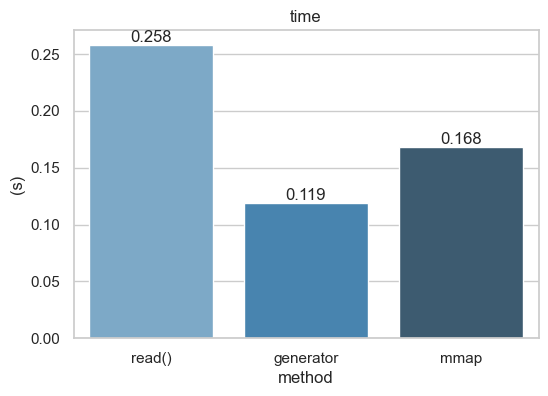

In [12]:
df.index.name = "method"

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(
    x="method",
    y="time (s)",
    hue="method",
    data=df.reset_index(),
    palette="Blues_d",
    dodge=False,
    legend=False,
)
plt.title("time")
plt.ylabel("(s)")
for i, v in enumerate(df["time (s)"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.show()

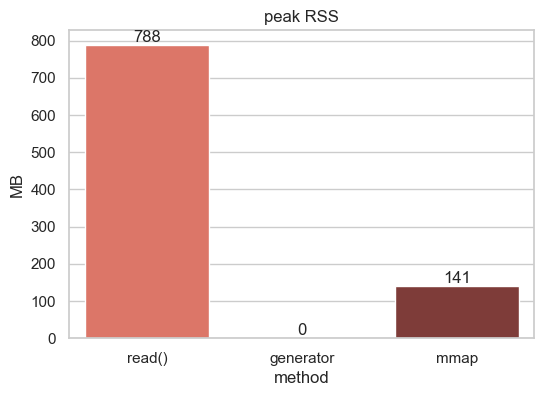

In [13]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x="method",
    y="peak RSS (MB)",
    hue="method",
    data=df.reset_index(),
    palette="Reds_d",
    dodge=False,
    legend=False,
)
plt.title("peak RSS")
plt.ylabel("MB")
for i, v in enumerate(df["peak RSS (MB)"]):
    plt.text(i, v, f"{v:.0f}", ha="center", va="bottom")
plt.show()